# Twin Delayed Deep Deterministic Policy Gradients (TD3) 

This notebook presents the [Twin Delayed Deep Deterministic Policy Gradients (a.k.a., TD3)](https://arxiv.org/pdf/1802.09477.pdf), which is an upgraded version of [Deep Deterministic Policy Gradients (DDPG)](https://arxiv.org/pdf/1509.02971.pdf). The code is from [this repository](https://github.com/sfujim/TD3/blob/master/TD3.py).

In [1]:
import sys
import gym
import copy
import time

import torch
import torch.autograd
import torch.nn            as nn
import torch.nn.functional as F 
import torch.optim         as optim
import numpy               as np
import matplotlib.pyplot   as plt
import moviepy.editor      as mpy

# Check whether GPU computation (i.e., CUDA) is available.
device = torch.device( "cuda" if torch.cuda.is_available( ) else "cpu" )

/Users/mosesnah/Documents/projects/machine-learning-tutorial/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Replay Buffer


In [2]:
class ReplayBuffer( object ):

    def __init__( self, n_state, n_action, max_size = 100000 ):

        # Save the dimension of state, dimension of action and the maximum size of the replay buffer
        self.n_state  = n_state
        self.n_action = n_action
        self.max_size = max_size

        # Defining the current size of the replay buffer, just to make the sampling easy. 
        self.current_size = 0

        # Defining the Index Pointer (ptr) of the replaybuffer. 
        # This is required for "adding" the experiences on the replaybuffer. 
        self.idx_ptr      = 0

        # Defining the 2D arrays of the ReplayBuffer
        # 2D array definition is necessary to forward the Neural Network
        self.states      = np.zeros( ( max_size, n_state   ) )
        self.actions     = np.zeros( ( max_size, n_action  ) )
        self.rewards     = np.zeros( ( max_size, 1         ) )
        self.next_states = np.zeros( ( max_size, n_state   ) )
        self.is_done     = np.zeros( ( max_size, 1         ) )


    def add( self, state, action, reward, next_state, is_done ):
        """
            Adding a state-action-reward-next_state pair into the ReplayBuffer. 
        """

        self.states[      self.idx_ptr ] = state
        self.actions[     self.idx_ptr ] = action
        self.rewards[     self.idx_ptr ] = reward
        self.next_states[ self.idx_ptr ] = next_state
        self.is_done[     self.idx_ptr ] = is_done

        # Update our index pointer. Note that the "oldest" experiences are overwritten.
        self.idx_ptr = ( self.idx_ptr + 1 ) % self.max_size

        # Update the current size of the replay buffer
        self.current_size = min( self.current_size + 1, self.max_size )

    def sample( self, n_batch_size ):
        """
            Collect "n_batch_size" samples from the replay buffer and return it as a batch.
        """
        idx = np.random.randint( 0, self.current_size, size = n_batch_size )

        # Returning the 2D numpy array as a 2D torch array.

        return ( 
            torch.FloatTensor(      self.states[ idx ]  ).to( device ) ,
            torch.FloatTensor(     self.actions[ idx ]  ).to( device ) , 
            torch.FloatTensor(     self.rewards[ idx ]  ).to( device ) ,
            torch.FloatTensor( self.next_states[ idx ]  ).to( device ) ,
            torch.FloatTensor(     self.is_done[ idx ]  ).to( device )   
        )


    def reset( self ):
        """
            Reset all the replay buffers to zeros
        """
        self.states      = np.zeros( ( self.max_size, self.n_state   ) )
        self.actions     = np.zeros( ( self.max_size, self.n_action  ) )
        self.rewards     = np.zeros( ( self.max_size, 1              ) )
        self.next_states = np.zeros( ( self.max_size, self.n_state   ) )
        self.is_done     = np.zeros( ( self.max_size, 1              ) )


# Actor and Critic Networks
As with the DDPG algorithm, TD3 also has two separate Actor and Critic Networks. The only difference is the critic of TD3 method has two separate neural networks to get two Q values, $Q_1$ and $Q_2$. The TD3 algorithm is inspired from Double Q-learning, which is the reason why we have $Q_1$ and $Q_2$. 

In [9]:
class Actor( nn.Module ):
    def __init__( self, n_state: int, n_action: int, n_hidden: int = 256, max_action: float = 1.0 ):

        # Class inheritance. 
        super( Actor, self ).__init__( )

        # Save the maximum action value 
        assert max_action >= 0
        self.max_action = max_action

        # First Layer, changes array  with size N x ( n_state  ) to N x ( n_hidden )
        self.l1 = nn.Linear(  n_state, n_hidden )

        # Second Layer, changes array with size N x ( n_hidden ) to N x ( n_hidden )
        self.l2 = nn.Linear( n_hidden, n_hidden )

        # Third Layer, changes array  with size N x ( n_hidden ) to N x ( n_action )
        self.l3 = nn.Linear( n_hidden, n_action )
        
    def forward( self, state ):
        
        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.l1( state ) )

        # Applying Rectified Linear Unit (ReLU) to x
        x = F.relu( self.l2( x ) )

        # Applying to tanh, which ranges the value from -1 to +1
        x = torch.tanh( self.l3( x ) ) 

        # Since the x value is from -1 to +1, we change the range to -max_action to +max_action.
        return x * self.max_action

class Critic( nn.Module ):
    """
        Learning the Q(s,a) function, which is the "Quality" function. Hence, input is a concatenation of state, action and the output is a scalar. 
    """
    def __init__( self, n_state, n_action, n_hidden: int = 256 ):

        # Class inheritance. 
        super( Critic, self ).__init__()


        # ================================================================================ #
        # ================================= First Q-Network ============================== #
        # ================================================================================ #
        # First Layer, changes array with size N x ( n_state + n_action ) to N x ( n_hidden )
        self.l1 = nn.Linear( n_state + n_action, n_hidden )

        # Second Layer, changes array with size N x ( n_hidden ) to N x ( n_hidden )
        self.l2 = nn.Linear( n_hidden, n_hidden )

        # Third Layer, changes array with size N x ( n_hidden ) to N x ( 1 ), since Q is a scalar function. 
        self.l3 = nn.Linear( n_hidden, 1 )

        # ================================================================================ #
        # ================================ Second Q-Network ============================== #
        # ================================================================================ #
        # First Layer, changes array with size N x ( n_state + n_action ) to N x ( n_hidden )
        self.l4 = nn.Linear( n_state + n_action, n_hidden )

        # Second Layer, changes array with size N x ( n_hidden ) to N x ( n_hidden )
        self.l5 = nn.Linear( n_hidden, n_hidden )

        # Third Layer, changes array with size N x ( n_hidden ) to N x ( 1 ), since Q is a scalar function. 
        self.l6 = nn.Linear( n_hidden, 1 )

        # Note that the first and second Q-networks has exactly the same structure. The parameters are only difference. 
    
    def forward( self, state, action ):

        # Concatenation of state and action vector.
        # The state  is assumed to be a 2D array with size N x n_s, where N is the number of samples
        # The action is assumed to be a 2D array with size N x n_a, where N is the number of samples
        # As a result of torch.cat( [ state, action ] along axis 1, ), we have size N x ( n_s + n_a ), and the dim = 0 must have the same size
        x = torch.cat( [ state, action ], dim = 1 )


        # ================================================================================ #
        # =========================== Calculating Q1 and Q2 ============================== #
        # ================================================================================ #

        # Applying Rectified Linear Unit (ReLU) to x
        q1 = F.relu( self.l1( x ) )
        q2 = F.relu( self.l4( x ) )

        # Applying Rectified Linear Unit (ReLU) to x
        q1 = F.relu( self.l2( q1 ) )
        q2 = F.relu( self.l5( q2 ) )

        # A simple Ax + b combination 
        q1 = self.l3( q1 )
        q2 = self.l6( q2 )

        # The output is a N x 1 array. 
        return q1, q2

    def Q1( self, state, action ):
        x = torch.cat( [ state, action ], dim = 1 )

        # Applying Rectified Linear Unit (ReLU) to x
        q1 = F.relu( self.l1( x ) )
        q1 = F.relu( self.l2( q1 ) )
        q1 = self.l3( q1 )

        return q1



class TD3( object ):

    def __init__( self, n_state, n_action, max_action, gamma = 0.99, tau = 0.005, policy_noise = 0.2, noise_clip = 0.5, policy_freq = 2 ):

        self.actor            = Actor( n_state, n_action, max_action = max_action ).to( device )
        self.actor_target     = copy.deepcopy( self.actor )
        self.actor_optimizer  = torch.optim.Adam( self.actor.parameters( ) , lr = 1e-4 )

        self.critic           = Critic( n_state, n_action ).to( device )
        self.critic_target    = copy.deepcopy( self.critic )
        self.critic_optimizer = torch.optim.Adam( self.critic.parameters( ), lr = 1e-3 )

        self.max_action = max_action

        self.gamma = gamma
        self.tau   = tau 

        self.policy_noise = policy_noise
        self.noise_clip   = noise_clip
        self.policy_freq  = policy_freq
        
        self.total_it = 0 

    def get_action( self, state ):

        # Conduct the a = mu(s), where mu is a "deterministic function"
        # Unsqueeze makes an 1 x n_s array of state. 
        state  = torch.from_numpy( state ).float( ).unsqueeze( 0 ).to( device )

        # Returns an 1 x n_a array of state
        # forward method can be omitted
        action = self.actor( state )

        # Change action from Torch to Numpy.
        # Since n_a is 1 for this case, action is simply an 1x1 array.
        # Hence, flattening the data. 
        action = action.cpu( ).data.numpy( ).flatten( )

        return action
    
    def update( self, replay_buffer, batch_size: int = 256 ):

        self.total_it += 1
        state, action, reward, next_state, is_done = replay_buffer.sample( batch_size )

        with torch.no_grad( ):
            noise       = ( torch.randn_like( action ) * self.policy_noise  ).clamp( -self.noise_clip, self.noise_clip )
            next_action = ( self.actor_target( next_state ) + noise ).clamp( -self.max_action, self.max_action )

            target_Q1, target_Q2 = self.critic_target( next_state, next_action )
            target_Q = torch.min( target_Q1, target_Q2 )
            target_Q = reward + (  ( 1. - is_done ) * self.gamma * target_Q )#.detach( )

		# Get current Q estimates
        current_Q1, current_Q2 = self.critic( state, action )

		# Compute critic loss
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

		# Delayed policy updates
        if self.total_it % self.policy_freq == 0:

			# Compute actor losse
            actor_loss = -self.critic.Q1( state, self.actor( state ) ).mean()
			
			# Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

			# Update the frozen target models
            for target_param, param in zip( self.critic_target.parameters( ), self.critic.parameters( ) ):
                target_param.data.copy_( self.tau * param.data + ( 1 - self.tau ) * target_param.data )
                
            for target_param, param in zip( self.actor_target.parameters( ) ,  self.actor.parameters( ) ):
                target_param.data.copy_( self.tau * param.data + ( 1 - self.tau ) * target_param.data )


    def save( self, filename ):
        
        torch.save( self.critic.state_dict( )           , filename + "_critic"              )
        torch.save( self.critic_optimizer.state_dict( ) , filename + "_critic_optimizer"    )
        
        torch.save( self.actor.state_dict( )            , filename + "_actor"               )
        torch.save( self.actor_optimizer.state_dict( )  , filename + "_actor_optimizer"     )


    def load( self, filename ):

        # Load Critic
        self.critic.load_state_dict(            torch.load( filename + "_critic"           )  )
        self.critic_optimizer.load_state_dict(  torch.load( filename + "_critic_optimizer" )  )
        self.critic_target = copy.deepcopy( self.critic )

        # Load Actor
        self.actor.load_state_dict(             torch.load( filename + "_actor"            )  )
        self.actor_optimizer.load_state_dict(   torch.load( filename + "_actor_optimizer"  )  )
        self.actor_target = copy.deepcopy( self.actor )


In [13]:
# Define instances of the environment, DDPG agent and the OU noise.
env   = gym.make( "Pendulum-v1" ) 

# Set the random seeds
env.seed(              round( time.time( ) ) )
env.action_space.seed( round( time.time( ) ) )
torch.manual_seed(     round( time.time( ) ) )
np.random.seed(        round( time.time( ) ) )

# Get the dimension of states and actions, and also the 
# [WARNING] This is for environments where we assume the mean of action is 0. 
n_state    = env.observation_space.shape[ 0 ] 
n_action   = env.action_space.shape[ 0 ]
max_action = float( env.action_space.high  )

# Define the agent, noise and replay buffers
agent         = TD3( n_state, n_action, max_action )
replay_buffer = ReplayBuffer( n_state, n_action )

# The number of "batch" that will be sampled from the replay buffer will be "batch_size" 
n_batch_size  = 256

# Saving these values to plot the performance at the end.
frames        = [ ]
whole_rewards = [ ]

# Flags for turning on or off the render.
is_save_video = False
is_save_model = False

# For the pendulum model the best reward is 0, hence saving a -infinity value. 
best_model_val = -np.inf

rewards       = [ ]
avg_rewards   = [ ]

for episode in range( 500 ):

    # Initialize the gym environment and OU noise 
    state = env.reset()

    # Initialize the episode's reward
    episode_reward = 0
    
    # For pendulum v1 gym, a single simulation is maximum 200-steps long. 
    # [REF] https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py
    for step in range( 200 ):

        # Get the action value from the deterministic policy Actor network.
        action = agent.get_action( state )

        if is_save_video : frames.append( env.render( mode = 'rgb_array' ) )

        # Apply the OU noise on this action

        # Run a single step of simulation
        new_state, reward, done, _ = env.step( action )  

        # Add this to our replay buffer, note that push simply generates the tuple and add 
        replay_buffer.add( state, action, reward, new_state, done )
        
        # Once the agent memory is full, then update the policy via replay buffer.
        if replay_buffer.current_size > n_batch_size: agent.update( replay_buffer, batch_size = n_batch_size )        
        
        # Update the state and reward value 
        state = new_state
        episode_reward += reward

        if done:
            break

    if best_model_val <= episode_reward:
        best_model_val = episode_reward 

        # If this policy has a good result, save it 
        if is_save_model: agent.save( "../models/DDPG_best_model" ) 

    # Once a single simulation is done, append the values that will be plotted later
    rewards.append( episode_reward )
    avg_rewards.append( np.mean( rewards[ -10 : ] ) )

    sys.stdout.write("episode: {}, reward: {}, average_reward: {} \n".format( episode, np.round( episode_reward, decimals = 2 ), avg_rewards[ -1 ] ) ) 

whole_rewards.append(  rewards  )

env.close( )

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/DDPG.gif" )



episode: 0, reward: -1060.9, average_reward: -1060.8965981419828 
episode: 1, reward: -1266.81, average_reward: -1163.851787087735 
episode: 2, reward: -1119.42, average_reward: -1149.042556829702 
episode: 3, reward: -1617.23, average_reward: -1266.0900278376178 
episode: 4, reward: -1657.32, average_reward: -1344.3353398362765 
episode: 5, reward: -1693.05, average_reward: -1402.4551019636995 
episode: 6, reward: -1661.87, average_reward: -1439.5147241865955 
episode: 7, reward: -1652.24, average_reward: -1466.104898909727 
episode: 8, reward: -1634.53, average_reward: -1484.819067235211 
episode: 9, reward: -1595.83, average_reward: -1495.9203691027753 
episode: 10, reward: -1697.29, average_reward: -1559.560014564065 
episode: 11, reward: -1510.33, average_reward: -1583.912381946961 
episode: 12, reward: -1303.28, average_reward: -1602.298213824563 
episode: 13, reward: -1415.23, average_reward: -1582.0984069592641 
episode: 14, reward: -1241.15, average_reward: -1540.4815400594355

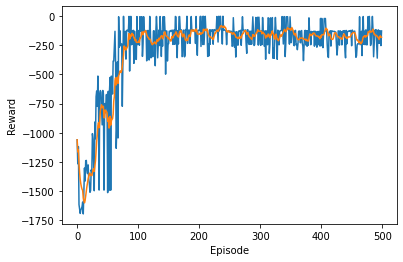

: 

In [14]:
plt.plot( rewards     )
plt.plot( avg_rewards )
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()